Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
import torch.nn as nn

from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid

import itertools

%matplotlib inline

# Fitting a variational auto-encoder

In part two of this coursework, you will fit a variational autoencoder to the MNIST dataset.

We'll download the data and plot a few images.

In [26]:
# Download the dataset and apply necessary transformations

mnist_transforms = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.round())])
mnist_dataset = MNIST(root='data/', download=True, train=True, transform=mnist_transforms)
train_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=100, shuffle=True)

## Data format

Each MNIST image $x_i$ is a **binary image** with shape `(1, 28, 28)`, i.e.

$$x_i \in \{0, 1\}^{1\times28\times28}$$

The first dimension is the number of "channels". It is `1` because these are black-and-white images. (For color images, there are three channels.)

The convention in pytorch is for images to be `[channels][rows][columns]`. This is different than numpy, which you might be familiar with, which instead has `[rows][columns][channels]`. We will have to call `torch.permute` to re-arrange the axes, sometimes.

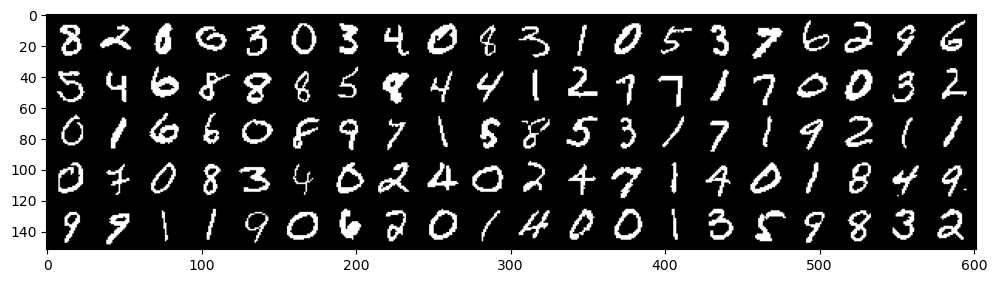

In [27]:
plt.figure(figsize=(12,5))
X_random_batch, y_random_batch = next(iter(train_loader))
plt.imshow(make_grid(X_random_batch, nrow=20).permute(1,2,0));

# TASK 1 (6 points + 2 bonus): Define encoder and decoder networks

We have data $x_i$ and will learn a latent representation $z_i \in \mathbb{R}^{D}$.

To do this we define two different networks, each as an `nn.Module` instance.


* The **Encoder** defines an inference network. It takes a batch of data instances as inputs, and returns a probability distribution $q(z_i | x_i)$ for each $x_i$ in the batch.
* The **Decoder** defines the likelihood in a generative model. It takes a latent value as input, and returns a probability distribution $p(x_i | z_i)$.

## You can use any network architecture you think is appropriate.

Part of your job here is to decide.

* You can get up to 6 points (3 points each) for having an implementation of any non-linear model that runs properly and can be used to fit some sort of VAE. If it doesn't quite work (or if you just implement a linear model, or a poor choice of architecture which leads to bad results) then you will get partial credit.

* You can get 2 additional points if you do something "interesting", by which I specifically mean "more performant". In particular we are looking for architectures which
    - (a) perform better than a feed-forward network, while 
    - (b) having fewer parameters.

In particular: for full *bonus* credit, for a model with `D_latent = 10` you should have fewer than 10,000 parameters each in the encoder and decoder, while still having realistic reconstructions. 


In [28]:
class Encoder(nn.Module):
    
    def __init__(self, D_latent):
        """ 
        Initialize the Encoder `nn.Module`.
        
        This will operate on inputs of shape (batch_size, 1, 28, 28).
        
        INPUTS:
        D_latent: size of latent space (integer)

        """
        super().__init__()
        self.D_latent = D_latent
        
        # Define any networks (which extend 'nn.Module') here:
        # Anything that has parameters should be defined here!
        # e.g., a linear layer could be defined as 
        # self.fc = nn.Linear(784, D_latent)
        # self.enc_conv_1 = nn.Conv2d(channels, n_filters, filter_size)
        # Later on in the `.forward` method, you then can call this.
        # Some ``useful'' layers include:
        # nn.Linear, nn.ReLU, nn.Conv2d, nn.Sequential, nn.Softplus, ...

        # YOUR CODE HERE
        # raise NotImplementedError()

        # (conv, relu, max pooling) x 2 , flatten, fc, 
        # output of convolution = (input_size - filter_size + 2* padding)/stride + 1
        
        self.flatten = nn.Flatten()
        # self.fc1 = nn.Linear(784, 256)
        # self.fc_mean = nn.Linear(256, D_latent)
        # self.fc_sd = nn.Linear(256, D_latent)
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()

        data_shape = (1, 28, 28)
        num_filters = 8
        filter_size = 3
        fc_prefinal_size = 16

        # init_bias = torch.zeros((1, 28, 28))
        # self.bias = nn.Parameter(init_bias, requires_grad=True)
        self.enc_conv_1 = nn.Conv2d(in_channels= data_shape[0], out_channels=num_filters*2, kernel_size=filter_size, padding=filter_size//2)
        self.bn_conv1 = nn.BatchNorm2d(num_filters*2)
        self.enc_conv_2 = nn.Conv2d(in_channels=num_filters*2, out_channels=num_filters, kernel_size=filter_size, padding=filter_size//2)
        self.bn_conv2 = nn.BatchNorm2d(num_filters)
        # self.fc1 = nn.LazyLinear(32)
        output_dim = int(7*7*num_filters) # conv1 (28), maxpooling (14), conv2 (14), maxpooling (7), output = 7*7*num_filters*2)
        self.fc1 =    nn.Linear(output_dim, fc_prefinal_size)  
        self.bn_fc1 = nn.BatchNorm1d(fc_prefinal_size)
        self.fc_mean = nn.Linear(fc_prefinal_size, D_latent)
        self.fc_sd = nn.Linear(fc_prefinal_size, D_latent)
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        

    def forward(self, X):
        """ Return a distribution q(z | x). 
        
        Remember you can access and variables or `nn.Module` instances defined in the constructor.
        
        INPUT:
        X    : torch.FloatTensor containing zeros and ones; shape = (batch_size, 1, 28, 28)
        
        OUTPUT: a `torch.Distribution` instance, defined on values of shape = (batch_size, D_latent)
        """
        
        # YOUR CODE HERE
        # raise NotImplementedError()

        #TODO: to optimize, use batchnorm, BiasLayer, DropOut...
        
        # MLP
        # X_flat = self.flatten(X)
        # h = self.relu(self.fc1(X_flat))
        # mu = self.fc_mean(h)
        # sigma = self.softplus(self.fc_sd(h))

        # X = X + self.bias
        X = self.maxpool(self.bn_conv1(self.relu(self.enc_conv_1(X))))
        X = self.maxpool(self.bn_conv2(self.relu(self.enc_conv_2(X))))
        X_flat = X.view(X.size(0), -1) 
        # X_flat = self.flatten(X, 1)

        h = self.bn_fc1(self.relu(self.fc1(X_flat)))
        mu = self.fc_mean(h)
        sigma = self.softplus(self.fc_sd(h)) #TODO: try
        # sigma = self.fc_sd(h)
        # sigma = torch.exp(0.5 * sigma) 

        # print("mu shape", mu.shape)
        # print("(X.shape[0], self.D_latent) ",(X.shape[0], self.D_latent))
        assert mu.shape == torch.Size([X.shape[0], self.D_latent])
        assert mu.shape == sigma.shape
        
        return dist.Normal(mu, sigma)
        
        # The following template might be helpful:
#         mu = ?
#         sigma = ?
#         assert mu.shape == (X.shape[0], self.D_latent)
#         assert mu.shape == sigma.shape
#         return dist.Normal(mu, sigma)


In [29]:
class Decoder(nn.Module):
    
    def __init__(self, D_latent):
        """ 
        Initialize the Decoder `nn.Module`.
        
        This will operate on inputs of shape (batch_size, D_latent).
        
        INPUTS:
        D_latent: size of latent space (integer)

        """
        super().__init__()
        self.D_latent = D_latent
        
        # Define your networks here
        # YOUR CODE HERE
        # raise NotImplementedError()

        # MLP
        # self.fc_z = nn.Linear(D_latent, 256)
        # self.fc1 = nn.Linear(256, 784)
        # self.relu = nn.ReLU()
        # self.sigmoid = nn.Sigmoid()


        fc_prefinal_size = 16
        num_filters = 8
        filter_size = 3
        conv_output_dim = 7
        conv_output_channels1 = num_filters 
        conv_output_channels2 = num_filters*2
        conv_output_size = conv_output_dim * conv_output_dim * conv_output_channels1

        # Define layers
        self.fc1 = nn.Linear(D_latent, fc_prefinal_size)
        self.fc2 = nn.Linear(fc_prefinal_size, conv_output_size)
        self.unflatten = nn.Unflatten(-1, (conv_output_channels1, conv_output_dim, conv_output_dim))
        self.deconv1 = nn.ConvTranspose2d(conv_output_channels1, conv_output_channels2, filter_size,padding=int(filter_size/2))
        self.deconv2 = nn.ConvTranspose2d(conv_output_channels2, 1, filter_size,padding= int(filter_size/2))
        self.relu = nn.ReLU()   
        self.bn_fc1 = nn.BatchNorm1d(fc_prefinal_size)
        self.bn_fc2 = nn.BatchNorm1d(conv_output_size)
        self.bn_conv1 = nn.BatchNorm2d(conv_output_channels2)
        
    def forward(self, Z):
        """ Return a distribution p(x | z) 
                
        INPUT:
        X    : torch.FloatTensor, real-valued, shape = (batch_size, D_latent)
        
        OUTPUT: a `torch.Distribution` instance, defined on values of shape = (batch_size, 1, 28, 28)
        """

        # Make sure that the returned value has the right shape! e.g.:
        # return dist.Bernoulli(X_hat.reshape(-1, 1, 28, 28))
        
        # YOUR CODE HERE
        # raise NotImplementedError()

        # MLP
        # h = self.relu(self.fc_z(Z))
        # reconstruction_logits = self.fc1(h)   
        # reconstruction_probs = torch.sigmoid(reconstruction_logits)

        h = self.relu(self.fc1(Z))
        h = self.bn_fc1(h)
        h = self.relu(self.fc2(h))
        h = self.bn_fc2(h)
        h = self.unflatten(h)
        h = nn.functional.interpolate(h, (14, 14))
        h = self.relu(self.deconv1(h))
        h = self.bn_conv1(h)
        h = nn.functional.interpolate(h, (28, 28))
        reconstruction_probs = torch.sigmoid(self.deconv2(h))

        return dist.Bernoulli(reconstruction_probs.reshape(-1, 1, 28, 28))
        

In [30]:
#My code
D_latent = 2
x = torch.randn(6,1,28,28)
enc = Encoder(D_latent)
zz = enc(x)
zz_sample = zz.rsample() 
print(zz)
print(zz_sample.shape)
dec = Decoder(D_latent)
print(dec(zz_sample).sample().shape)

Normal(loc: torch.Size([6, 2]), scale: torch.Size([6, 2]))
torch.Size([6, 2])
torch.Size([6, 1, 28, 28])


In [31]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

D_latent = 10
model = Encoder(D_latent)
dummy_input = torch.randn(3, 1, 28, 28)
model(dummy_input)
total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params}")
model = Decoder(D_latent)
total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 8028
Total trainable parameters: 9001


In [32]:
# #My code - delete
# # Try modifying this and seeing how it affects performance!
# D_latent = 10
# enc = Encoder(D_latent)
# dec = Decoder(D_latent)
# opt_vae = torch.optim.Adam(itertools.chain(enc.parameters(), dec.parameters()))
# loss_fn = nn.BCELoss(reduction="sum")
# def run_training(N_epochs, enc, dec):
#     """ Outer loop for training the VAE 
    
#         Calls your `ELBO_VAE` function!
#     """
#     for epoch in range(N_epochs):
#         train_loss = 0.0
#         for (X, _) in train_loader:
#             opt_vae.zero_grad()
            
#             # Call you ELBO implementation
#             # elbos = ELBO_VAE(enc, dec, X)

#             # # Normalize and reshape X here if it hasn't been done already
#             # X = X.view(X.size(0), -1)  # Flatten the images if they are not already flat
#             # X = X.to(torch.float32)  # Ensure X is float
#             # if torch.max(X) > 1:
#             #     X /= 255.0  # Normalize X to be in [0, 1] if not already
    
#             # mu, std = enc(X)
#             # eps = torch.randn_like(std)
#             # z = mu + eps * std
#             encoded_distr = enc(X)
#             z_sample = encoded_distr.rsample()  
#             reconstructed_distr = dec(z_sample)
            
#             # z_distr = enc(X)
#             # reconstructed_img_sigmoid = dec(z_distr.sample())

#             reconstr_loss = loss_fn(reconstructed_distr.probs,X)
#             std_dev = encoded_distr.stddev.clamp(min=1e-5)
#             kl_div = -0.5 * torch.sum(1 + torch.log(std_dev**2) - encoded_distr.mean**2 - std_dev**2)
#             # kl_div = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)
            
#             # Please don't break the following assertion (check your return shape!)
#             batch_size = X.shape[0]
#             # assert elbos.shape == (batch_size,)
            
#             # The loss is the sum of the negative per-datapoint ELBO
#             # print(reconstr_loss, kl_div)
#             loss = reconstr_loss+kl_div
#             loss.backward()
#             opt_vae.step()
#             # train_loss += loss.item()
#             train_loss += loss.item() * X.shape[0] / len(mnist_dataset)
#         # Normalize train_loss by the dataset size, not by batch size
#         # train_loss /= len(mnist_dataset)
#         print("Epoch %d, train loss = %0.4f" % (epoch, train_loss))

# N_epochs = 5 # Note that you may want to run more epochs!
# run_training(N_epochs, enc, dec)

# # def get_z(encoded_mean):
# #     mu, std = encoded_mean
# #     eps = torch.randn_like(std)
# #     z = mu + eps * std
# #     return z

# plt.figure(figsize=(12, 4))
# plt.imshow(make_grid(X_random_batch, nrow=20).permute(1,2,0))
# plt.title("Input images")
# plt.figure(figsize=(12, 4))

# # plt.title("Reconstructions")
# # print(X_random_batch.shape)
# # print(dec(get_z(enc(X_random_batch))).shape)
# # with torch.no_grad():
# #     plt.imshow(make_grid(dec(get_z(enc(X_random_batch))), nrow=20).permute(1,2,0))
# # print("Reconstruction accuracy: %0.2f" % (X_random_batch == dec(get_z(enc(X_random_batch)))).float().mean().item())

# plt.figure(figsize=(12, 4))
# plt.title("Reconstructions")
# with torch.no_grad():
#     plt.imshow(make_grid(dec(enc(X_random_batch).sample()).mean.round(), nrow=20).permute(1,2,0))
    
# print("Reconstruction accuracy: %0.2f" % (X_random_batch == dec(enc(X_random_batch).sample()).sample()).float().mean().item())

# TASK 2 (5 points): Define the objective function

You now need to define the ELBO, which we will maximize when estimating parameters in the encoder and decoder.

## Please use a standard normal prior $N(0, I)$ for the latent space.

I.e., let $$z \sim \mathcal{N}(0, I_D)$$ where $D$ is the dimensionality of the latent space.

The `ELBO_VAE` function should return a **single-sample** Monte Carlo estimate of

$$ELBO(x_i) = \mathbb{E}_{q(z_i | x_i)}\left[ \log \left [ \frac{p(z_i)p(x_i | z_i)}{q(z_i | x_i)} \right ] \right ]$$

where $q(z_i | x_i)$ and $p(x_i | z_i)$ are returned by the `Encoder` and `Decoder` classes you defined above.

Note that I have written this as the **per-datapoint** ELBO. 

For ease of inspecting your code, please have your `ELBO_VAE` function below return a Torch vector, i.e. a tensor of shape `(batch_size,)`, containing the per-datapoint ELBO values.


In [33]:
def ELBO_VAE(enc, dec, X):
    """
    
    INPUT:
    enc : Instance of `Encoder` class, which returns a distribution 
          over Z when called on a batch of inputs X
    dec : Instance of `Decoder` class, which returns a distribution 
          over X when called on a batch of inputs Z
    X   : A batch of datapoints, torch.FloatTensor of shape = (batch_size, 1, 28, 28)
    
    
    OUTPUT: a torch.FloatTensor of shape = (batch_size, ) containing the estimate 
            of the per-datapoint ELBO for every data point in the batch.
    
    """

    # YOUR CODE HERE
    # raise NotImplementedError()

    # Optimized_ELBO = Reconstruction_term - Regularization_term (KL divergence - closed form of Gaussian encoder)
    # prior_z =  dist.MultivariateNormal(torch.zeros(X.shape[0]), torch.eye(X.shape[0])) #.log_prob(X)

    latent_space = dist.Normal(0,1)

    # generate latent variables from encoder
    zi = enc(X).rsample()
    # getting reconstructed data from decoder ??

    # logprob of latent samples from standard normal distribution  
    p_zi = latent_space.log_prob(zi).sum(dim=1)
    # logprob of original data given the latent samples(X/Z)
    p_xi_given_zi = dec(zi).log_prob(X).reshape(X.size(0),-1).sum(dim=1)
    # logprob of latent samples under the encoder's distribution(Z/X)
    q_zi_given_xi = enc(X).log_prob(zi).sum(dim=1)

#     print(p_zi.shape, p_xi_given_zi.shape, q_zi_given_xi.shape)
    elbo = p_zi + p_xi_given_zi - q_zi_given_xi
    return elbo

#     loss_fn = nn.BCELoss(reduction="none")
#     # latent distribution q(z|x)
    
#     latent_distr = enc(X)
#     z_sample = latent_distr.rsample()  
#     # distribution p(x|z)
#     reconstructed_distr = dec(z_sample)
#     # get per datapoint reconstruction
#     reconstr_loss = loss_fn(reconstructed_distr.probs, X).view(X.size(0), -1).sum(dim=1)

#     # KL divergence between q(z|x) and p(z)
#     std_dev = latent_distr.stddev.clamp(min=1e-5)
#     kl_div = -0.5 * torch.sum(1 + torch.log(std_dev**2) - latent_distr.mean**2 - std_dev**2, dim=1) #dim=1
#     #     print(reconstr_loss, kl_div)
#     loss = reconstr_loss + kl_div
#     return -loss
    

# Train the VAE and look at the results

The following code to train and run the VAE has already been written for you. 

You can use it to evaluate whether or not your model is working as you might expect, and for experimenting with its behavior as you change different parameters.

You should't have to change the two following cells. Feel free to modify them (e.g. for adding debugging information), but be aware that I will test your implementations with substantially similar code. So, your code should be runnable by calling these cells as-is.

In [34]:
# Try modifying this and seeing how it affects performance!
D_latent = 10

enc = Encoder(D_latent)
dec = Decoder(D_latent)

opt_vae = torch.optim.Adam(itertools.chain(enc.parameters(), dec.parameters()))

In [35]:
def run_training(N_epochs, enc, dec):
    """ Outer loop for training the VAE 
    
        Calls your `ELBO_VAE` function!
    """
    for epoch in range(N_epochs):
        train_loss = 0.0
        for (X, _) in train_loader:
            opt_vae.zero_grad()
            
            # Call you ELBO implementation
            elbos = ELBO_VAE(enc, dec, X)
            
            # Please don't break the following assertion (check your return shape!)
            batch_size = X.shape[0]
            assert elbos.shape == (batch_size,)
            
            # The loss is the sum of the negative per-datapoint ELBO
            loss = -elbos.sum()
            loss.backward()
            opt_vae.step()
            train_loss += loss.item() * X.shape[0] / len(mnist_dataset)
        print("Epoch %d, train loss = %0.4f" % (epoch, train_loss));

In [36]:
# ignore this cell (placeholder)


In [37]:
N_epochs = 5 # Note that you may want to run more epochs!
run_training(N_epochs, enc, dec)

Epoch 0, train loss = 24691.1172
Epoch 1, train loss = 15131.0444
Epoch 2, train loss = 13559.2458
Epoch 3, train loss = 12586.6134
Epoch 4, train loss = 12130.9613


## Do reconstructions look like the input?

Reconstruction accuracy: 0.92


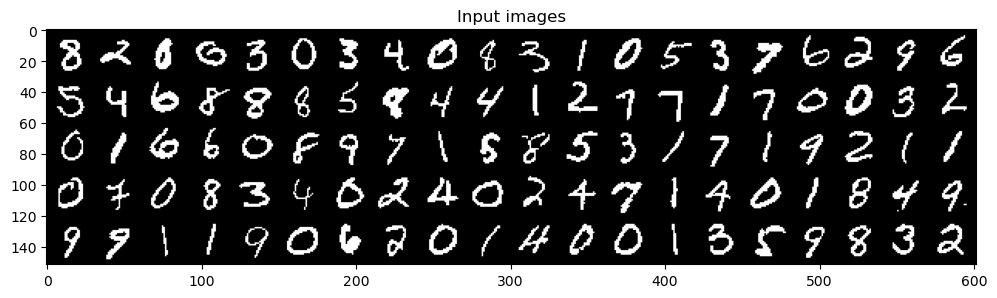

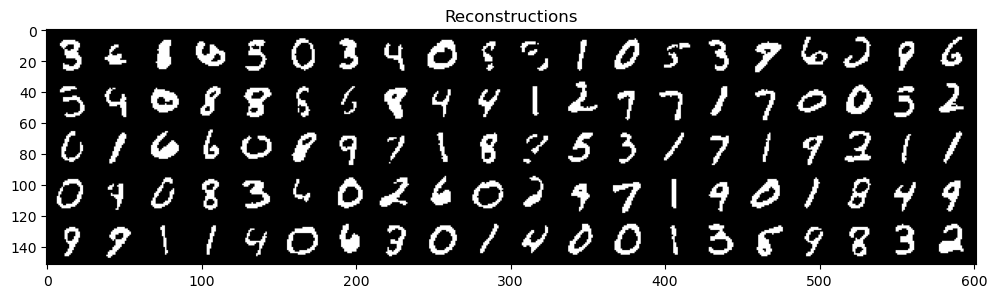

In [38]:
plt.figure(figsize=(12, 4))
plt.imshow(make_grid(X_random_batch, nrow=20).permute(1,2,0))
plt.title("Input images")
plt.figure(figsize=(12, 4))
plt.title("Reconstructions")
with torch.no_grad():
    plt.imshow(make_grid(dec(enc(X_random_batch).sample()).mean.round(), nrow=20).permute(1,2,0))
    
print("Reconstruction accuracy: %0.2f" % (X_random_batch == dec(enc(X_random_batch).sample()).sample()).float().mean().item())

## Do randomly generated samples look coherent?

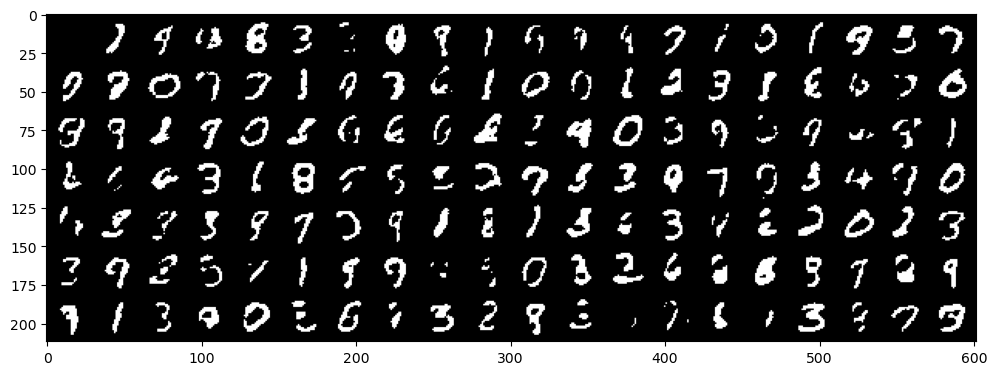

In [39]:
plt.figure(figsize=(12,5))
with torch.no_grad():
    plt.imshow(make_grid(dec(dist.Normal(0, 1).sample((140, D_latent))).mean.round(), nrow=20).permute(1,2,0), vmin=0, vmax=1)

## What does the latent space look like?

Note that this will only give sensible plots for very low-dimensional latent spaces. It works best if the latent space is actually 2d. Otherwise, it will plot a 2d cross-section that may or may not be informative.

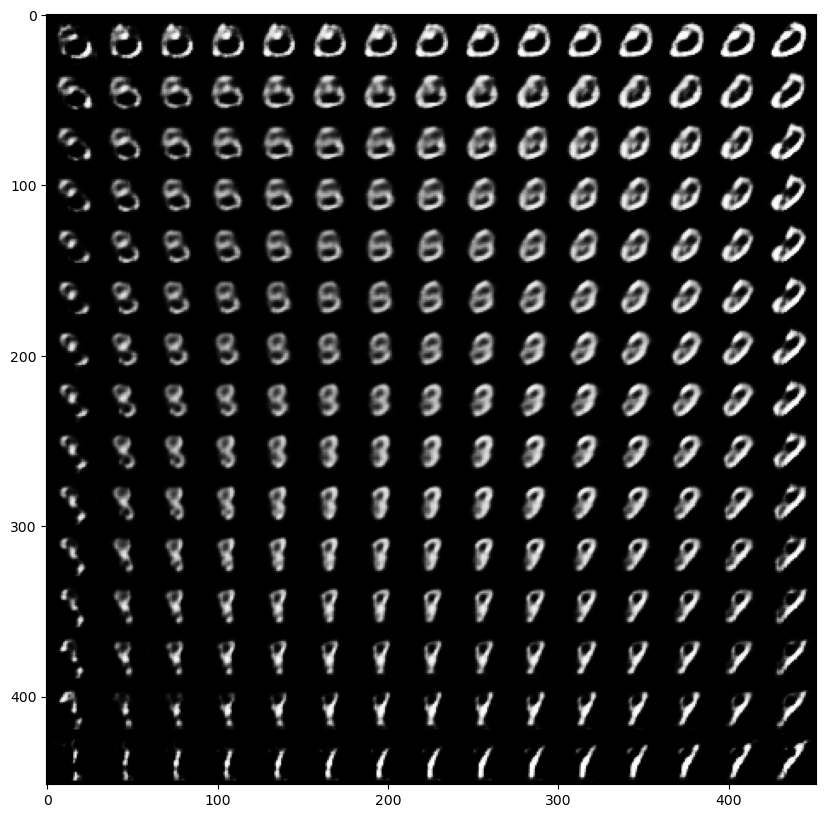

In [40]:
def plot_2d_latent(encoder, decoder):
    """ If this is a 2d latent space, it plots the latent space
        If the latent space is larger than 2d, then it plots a 2d cross-section """
    W = torch.linalg.svd(encoder(X_random_batch).mean).Vh[:2]
    points = dist.Normal(0, 1).icdf(torch.linspace(0.01, 0.99, 15))
    XX, YY = torch.meshgrid(points, points)
    XXYY = torch.stack((XX, YY)).reshape(2, -1).T
    with torch.no_grad():
        out = dec(XXYY @ W).mean
    plt.imshow(make_grid(out, nrow=len(points)).permute(1,2,0))

plt.figure(figsize=(10, 10))
out = plot_2d_latent(enc, dec)

In [41]:
# feel free to try out other things here -- for example, interpolation in the latent space between two digits

In [42]:
# grading


In [43]:
# grading


In [44]:
# grading


In [45]:
# grading


In [46]:
# grading


In [47]:
# grading


In [48]:
# grading
